In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import SVHN
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from random import randrange


In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [68]:
trainset = SVHN(root='../data', split='train', download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = SVHN(root='../data', split='test', download=True, transform=transform)
testloader = DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)


Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [58]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

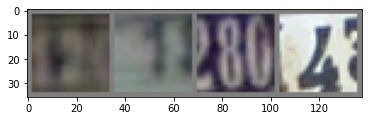

         2         1         8         4


In [59]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))
# print labels
print(''.join('%10s' % classes[labels[j]] for j in range(4)))

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Convolution 1
        self.conv1=nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5,stride=1, padding=2)
        nn.init.normal_(self.conv1.weight, std=0.001)
        nn.init.constant_(self.conv1.bias, 0)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1= nn.ReLU()
        self.maxpool1= nn.MaxPool2d(kernel_size=2,stride=2)

        #Convolution 2
        self.conv2=nn.Conv2d(in_channels=6,out_channels=12, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv2.weight, std=0.001)
        nn.init.constant_(self.conv2.bias, 0)
        self.bn2 = nn.BatchNorm2d(12)
        self.relu2= nn.ReLU()
        self.maxpool2= nn.MaxPool2d(kernel_size=2,stride=2)
        
        #Convolution 3
        self.conv3=nn.Conv2d(in_channels=12,out_channels=24, kernel_size=3,stride=1, padding=1)
        nn.init.normal_(self.conv3.weight, std=0.001)
        nn.init.constant_(self.conv3.bias, 0)
        self.bn3 = nn.BatchNorm2d(24)
        self.relu3= nn.ReLU()
        self.maxpool3= nn.MaxPool2d(kernel_size=2,stride=2)
        
        ### fully connected layer
        self.fc_input_size = 24*4*4
        self.fc4 = nn.Linear(self.fc_input_size, 10)
        nn.init.normal_(self.fc4.weight, std=0.001)
        nn.init.constant_(self.fc4.bias, 0)
        
    def forward(self,x):
        # conv layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # final layer
        x = x.view(-1, self.fc_input_size)
        x = self.fc4(x)
        return(x)    

In [61]:
# Function to calculate accuracy
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to('cuda')
            labels = labels.squeeze().to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    model.train()
    return 100 * correct / total
    

In [85]:
# Build Training Loop

# create model instance
model_conv = Net().to('cuda')
model_conv.train()

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Create the optimizer
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)

# Construct the training loop
NUM_EPOCHS = 50

for j in range(NUM_EPOCHS):   
    for i_batch, [images,labels] in enumerate(trainloader):
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad() # Clear out accumulated gradients
        output = model_conv(images) # forward pass
        loss = loss_fn(output, (labels.long()).squeeze()) # calculate loss
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters

    if j % 1 == 0:
        accuracy = get_accuracy(model_conv,testloader)
        print("Epoch", j, "Training Loss: ", loss.item(), "Test Accuracy: ", accuracy) 

Epoch 0 Training Loss:  0.9971420764923096 Test Accuracy:  77.14735709895513
Epoch 1 Training Loss:  0.2656046152114868 Test Accuracy:  82.69437615242778
Epoch 2 Training Loss:  0.33680394291877747 Test Accuracy:  83.51644130301167
Epoch 3 Training Loss:  0.41847118735313416 Test Accuracy:  85.41410571604179
Epoch 4 Training Loss:  0.8502851128578186 Test Accuracy:  86.75476336816226
Epoch 5 Training Loss:  0.39079535007476807 Test Accuracy:  86.31299938537185
Epoch 6 Training Loss:  0.3171314597129822 Test Accuracy:  86.47433927473878
Epoch 7 Training Loss:  0.21834471821784973 Test Accuracy:  85.21819299323909
Epoch 8 Training Loss:  0.11116869002580643 Test Accuracy:  88.06468961278426
Epoch 9 Training Loss:  0.36593377590179443 Test Accuracy:  86.04025814382298
Epoch 10 Training Loss:  0.21054089069366455 Test Accuracy:  87.34250153657038
Epoch 11 Training Loss:  0.7931790351867676 Test Accuracy:  87.84572833435772
Epoch 12 Training Loss:  0.23153142631053925 Test Accuracy:  87.069

True Label:  1  Predicted Label:  1


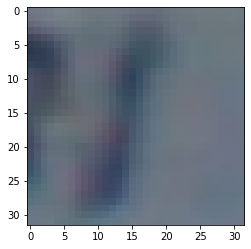

-------------
True Label:  7  Predicted Label:  7


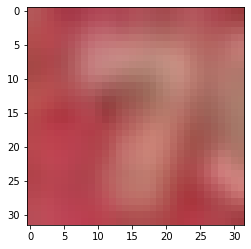

-------------
True Label:  1  Predicted Label:  7


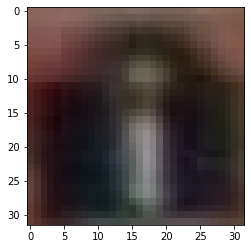

-------------
True Label:  5  Predicted Label:  5


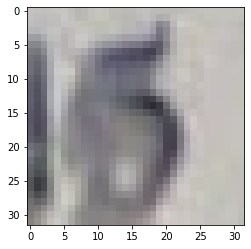

-------------
True Label:  2  Predicted Label:  2


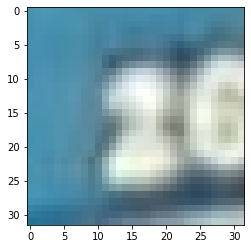

-------------


In [91]:
# Run Inference

# evaluate the model on an example batch
images,labels = next(iter(testloader))
images = images.to('cuda')
labels = labels.to('cuda')
model_conv.eval()
with torch.no_grad():
  outputs = model_conv(images)

# Display Result
for i in range(5):
    index = randrange(512)
    im = images[index].cpu()
    lbl = labels[index].cpu().numpy().squeeze()
    _,pred = torch.max(outputs[index],0)
    pred = pred.cpu().numpy()
    
    print("True Label: ", lbl, " Predicted Label: ",pred  )
    imshow(im)
    plt.show()
    print("-------------")